# Parameter Values

In this notebook, we explain how parameter values are set for a model. Information on how to add parameter values is provided in our [online documentation](https://pybamm.readthedocs.io/en/latest/tutorials/add-parameter-values.html)

## Setting up parameter values

In [1]:
%pip install pybamm -q    # install PyBaMM if it is not installed
import pybamm
import tests
import numpy as np
import os
import matplotlib.pyplot as plt
from pprint import pprint
os.chdir(pybamm.__path__[0]+'/..')

Note: you may need to restart the kernel to use updated packages.


In `pybamm`, the object that sets parameter values for a model is the `ParameterValues` class, which extends `dict`. This takes the values of the parameters as input, which can be either a dictionary,

In [2]:
param_dict = {"a": 1, "b": 2, "c": 3}
parameter_values = pybamm.ParameterValues(param_dict)
print("parameter values are {}".format(parameter_values))

parameter values are {'a': 1,
 'b': 2,
 'c': 3}


or a csv file,

In [3]:
f = open("param_file.csv", "w+")
f.write(
"""
Name [units],Value
a, 4
b, 5
c, 6
"""
)
f.close()

parameter_values = pybamm.ParameterValues("param_file.csv")
print("parameter values are {}".format(parameter_values))

parameter values are {'a': 4,
 'b': 5,
 'c': 6}


or using one of the pre-set chemistries

In [4]:
print("Marquis2019 chemistry set is {}".format(pybamm.parameter_sets.Marquis2019))
chem_parameter_values = pybamm.ParameterValues("Marquis2019")
print("Negative current collector thickness is {} m".format(
    chem_parameter_values["Negative current collector thickness [m]"])
)

Marquis2019 chemistry set is {'chemistry': 'lithium-ion', 'cell': 'kokam_Marquis2019', 'negative electrode': 'graphite_mcmb2528_Marquis2019', 'separator': 'separator_Marquis2019', 'positive electrode': 'lico2_Marquis2019', 'electrolyte': 'lipf6_Marquis2019', 'experiment': '1C_discharge_from_full_Marquis2019', 'sei': 'example', 'citation': 'Marquis2019'}
Negative current collector thickness is 2.5e-05 m


We can input functions into the parameter values, either directly (note we bypass the check that the parameter already exists)

In [5]:
def cubed(x):
    return x ** 3
parameter_values.update({"cube function": cubed}, check_already_exists=False)
print("parameter values are {}".format(parameter_values))

parameter values are {'a': 4,
 'b': 5,
 'c': 6,
 'cube function': <function cubed at 0x7f4a612c9af0>}


or by using `pybamm.load_function` to load from a path to the function

In [6]:
f = open("squared.py","w+")
f.write(
"""
def squared(x):
    return x ** 2
"""
)
f.close()
parameter_values.update({"square function": pybamm.load_function("squared.py")}, check_already_exists=False)
print("parameter values are {}".format(parameter_values))
os.remove("squared.py")

parameter values are {'a': 4,
 'b': 5,
 'c': 6,
 'cube function': <function cubed at 0x7f4a612c9af0>,
 'square function': <function squared at 0x7f4a612c9ee0>}


## Setting parameters for an expression

We represent parameters in models using the classes `Parameter` and `FunctionParameter`. These cannot be evaluated directly,

In [7]:
a = pybamm.Parameter("a")
b = pybamm.Parameter("b")
c = pybamm.Parameter("c")
func = pybamm.FunctionParameter("square function", {"a": a})

expr = a + b * c
try:
    expr.evaluate()
except NotImplementedError as e:
    print(e)

method self.evaluate() not implemented
               for symbol a of type <class 'pybamm.expression_tree.parameter.Parameter'>


However, the `ParameterValues` class can walk through an expression, changing an `Parameter` objects it sees to the appropriate `Scalar` and any `FunctionParameter` object to the appropriate `Function`, and the resulting expression can be evaluated

In [8]:
expr_eval = parameter_values.process_symbol(expr)
print("{} = {}".format(expr_eval, expr_eval.evaluate()))

34.0 = 34.0


In [9]:
func_eval = parameter_values.process_symbol(func)
print("{} = {}".format(func_eval, func_eval.evaluate()))

16.0 = 16.0


If a parameter needs to be changed often (for example, for convergence studies or parameter estimation), the `InputParameter` class should be used. This is not fixed by parameter values, and its value can be set on evaluation (or on solve):

In [10]:
d = pybamm.InputParameter("d")
expr = 2 + d
expr_eval = parameter_values.process_symbol(expr)
print("with d = {}, {} = {}".format(3, expr_eval, expr_eval.evaluate(inputs={"d": 3})))
print("with d = {}, {} = {}".format(5, expr_eval, expr_eval.evaluate(inputs={"d": 5})))

with d = 3, 2.0 + d = 5.0
with d = 5, 2.0 + d = 7.0


## Solving a model

The code below shows the entire workflow of:

1. Proposing a toy model
2. Discretising and solving it first with one set of parameters,
3. then updating the parameters and solving again

The toy model used is:
$$\frac{\mathrm{d} u}{\mathrm{d} t} = -a u$$

with initial conditions $u(0) = b$. The model is first solved with $a = 3, b = 2$, then with $a = 4, b = -1$

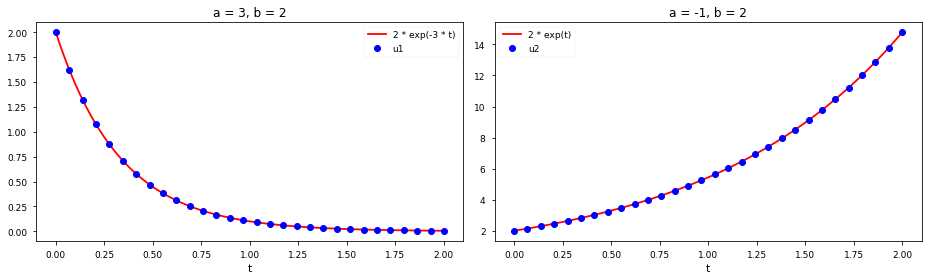

In [11]:
# Create model
model = pybamm.BaseModel()
u = pybamm.Variable("u")
a = pybamm.Parameter("a")
b = pybamm.Parameter("b")
model.rhs = {u: -a * u}
model.initial_conditions = {u: b}
model.variables = {"u": u, "a": a, "b": b}

# Set parameters, with a as an input ########################
parameter_values = pybamm.ParameterValues({"a": "[input]", "b": 2})
parameter_values.process_model(model)
#############################################################

# Discretise using default discretisation
disc = pybamm.Discretisation()
disc.process_model(model)

# Solve
t_eval = np.linspace(0, 2, 30)
ode_solver = pybamm.ScipySolver()
solution = ode_solver.solve(model, t_eval, inputs={"a": 3})

# Post-process, so that u1 can be called at any time t (using interpolation)
t_sol1 = solution.t
u1 = solution["u"]

# Solve again with different inputs ###############################
solution = ode_solver.solve(model, t_eval, inputs={"a": -1})
t_sol2 = solution.t
u2 = solution["u"]
###################################################################

# Plot
t_fine = np.linspace(0,t_eval[-1],1000)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,4))
ax1.plot(t_fine, 2 * np.exp(-3 * t_fine), t_sol1, u1(t_sol1), "o")
ax1.set_xlabel("t")
ax1.legend(["2 * exp(-3 * t)", "u1"], loc="best")
ax1.set_title("a = 3, b = 2")

ax2.plot(t_fine, 2 * np.exp(t_fine), t_sol2, u2(t_sol2), "o")
ax2.set_xlabel("t")
ax2.legend(["2 * exp(t)", "u2"], loc="best")
ax2.set_title("a = -1, b = 2")


plt.tight_layout()
plt.show()

In [12]:
model.rhs

{Variable(0x7456bacb36d28b68, u, children=[], domain=[], auxiliary_domains={}): Multiplication(0x76b039596794144b, *, children=['-a', 'y[0:1]'], domain=[], auxiliary_domains={})}

## Printing parameter values

In most models, it is useful to define dimensionless parameters, which are combinations of other parameters. However, since parameters objects must be processed by the `ParameterValues` class before they can be evaluated, it can be difficult to quickly check the value of a dimensionless parameter. 

You can print all of the dimensionless parameters in a model by using the `print_parameters` function. Note that the `print_parameters` function also gives the dependence of the parameters on C-rate (as some dimensionless parameters vary with C-rate), but we can ignore that here

In [13]:
a = pybamm.Parameter("a")
b = pybamm.Parameter("b")
parameter_values = pybamm.ParameterValues({"a": 4, "b": 3})
parameters = {"a": a, "b": b, "a + b": a + b, "a * b": a * b}
param_eval = parameter_values.print_parameters(parameters)
for name, (value,C_dependence) in param_eval.items():
    print("{}: {}".format(name, value))

a: 4.0
b: 3.0
a + b: 7.0
a * b: 12.0


If you provide an output file to `print_parameters`, the parameters will be printed to that output file.

## References

The relevant papers for this notebook are:

In [14]:
pybamm.print_citations()

[1] Joel A. E. Andersson, Joris Gillis, Greg Horn, James B. Rawlings, and Moritz Diehl. CasADi – A software framework for nonlinear optimization and optimal control. Mathematical Programming Computation, 11(1):1–36, 2019. doi:10.1007/s12532-018-0139-4.
[2] Charles R. Harris, K. Jarrod Millman, Stéfan J. van der Walt, Ralf Gommers, Pauli Virtanen, David Cournapeau, Eric Wieser, Julian Taylor, Sebastian Berg, Nathaniel J. Smith, and others. Array programming with NumPy. Nature, 585(7825):357–362, 2020. doi:10.1038/s41586-020-2649-2.
[3] Scott G. Marquis, Valentin Sulzer, Robert Timms, Colin P. Please, and S. Jon Chapman. An asymptotic derivation of a single particle model with electrolyte. Journal of The Electrochemical Society, 166(15):A3693–A3706, 2019. doi:10.1149/2.0341915jes.
[4] Valentin Sulzer, Scott G. Marquis, Robert Timms, Martin Robinson, and S. Jon Chapman. Python Battery Mathematical Modelling (PyBaMM). ECSarXiv. February, 2020. doi:10.1149/osf.io/67ckj.
[5] Pauli Virtanen, 